# Example 1: T19T + U19G CY5

## Gather required libraries

In [1]:
import scipy
from scipy.integrate import odeint
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

## Test data

In [2]:
data = pd.read_csv("T19T + U19G CY5_results.csv", comment='#',sep=',') #T19T + U19G CY5
data

,Time_Points,Substrate,Product_1,Product_2
0,0,1.000,0.000,0.000
1,10,0.440,0.024,0.054
2,30,0.216,0.099,0.168
3,60,0.164,0.105,0.201
4,180,0.111,0.123,0.240
5,360,0.079,0.117,0.249
6,1800,0.056,0.216,0.161
7,6000,0.000,0.155,0.224


In [3]:
# Given data (time and substrate concentration)

time_data = np.array(data["Time_Points"])  # Time points
substrate_data = np.array(data["Substrate"])  # Substrate concentration over time
product_data1 = np.array(data["Product_1"])  # Concentration of product 1 over time
product_data2 = np.array(data["Product_2"])  # Concentration of product 2 over time

## Define functions

In [4]:
# Define exponential depletion function for substrate (initial DNA)
def initial_dna_depletion(t, k_depletion):
    return np.exp(-k_depletion * t)

#-------------------------------------------------------------------------------------------------------------------------------

# Define exponential growth function for product formation 
def product_formation_system_1(t, k_formation1, k_formation2, C1):
    C2 = 1 - C1
    formation_product1 = C1 * (1 - np.exp(-k_formation1 * t))
    formation_product2 = C2 * (1 - np.exp(-k_formation2 * t))
    return formation_product1, formation_product2

# Define the coupled ODE system for substrate depletion and product formation 
def ode_system_1(t, y, k_depletion, k_formation1, k_formation2, C1):
    S, P1, P2 = y
    C2 = 1 - C1
    dSdt = -k_depletion * S
    dP1dt = k_formation1 * S * C1 * (1 - P2-S)
    dP2dt = k_formation2 * S * C2 * (1 - P1-S)
    return [dSdt, dP1dt, dP2dt]

# Define the objective function for least squares minimization 
def objective_function_1(params):
    k_depletion, k_formation1, k_formation2, C1 = params
    # params is a list or array containing the parameters that we want to optimize
    y_predicted = solve_ivp(lambda t, y: ode_system_1(t, y, k_depletion, k_formation1, k_formation2, C1), [time_data[0],
                                                    time_data[-1]], [substrate_data[0], product_data1[0], product_data2[0]],
                                                    t_eval=time_data).y
    
    #The solve_ivp function from scipy.integrate is used to numerically solve the system of ordinary differential equations 
    #(ODEs) defined by the function ode_system.
    
    #We pass the parameters (k_depletion, k_formation1, k_formation2, and C1) along with the initial conditions
    #([substrate_data[0], product_data1[0], product_data2[0]]) to the ode_system.
    
    #The time span for integration is defined by [time_data[0], time_data[-1]], where time_data contains the time points at 
    #which the data is observed.

    #t_eval=time_data ensures that the solver evaluates the solution at the same time points where the data is available.

    residuals_substrate = y_predicted[0] - substrate_data
    residuals_product1 = y_predicted[1] - product_data1
    residuals_product2 = y_predicted[2] - product_data2
    return np.concatenate((residuals_substrate, residuals_product1, residuals_product2))

#-------------------------------------------------------------------------------------------------------------------------------

def r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

def sum_squared_residuals(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

## Perform fitting

In [5]:
# Initial guess for parameters
initial_guess1 = [0.1, 0.1, 0.1, 0.5]  # Example initial guess for the parameters

# Fit the objective function to the data using least squares
result = least_squares(objective_function_1, initial_guess1)

# Extract the optimal parameters
k_depletion_opt, k_formation1_opt1, k_formation2_opt1, fraction_opt = result.x

# Generate points for the fitted curves for substrate and products
substrate_fit = initial_dna_depletion(time_data, k_depletion_opt)
product1_fit1, product2_fit1 = product_formation_system_1(time_data, k_formation1_opt1, k_formation2_opt1, fraction_opt)

## Plot the fitting 

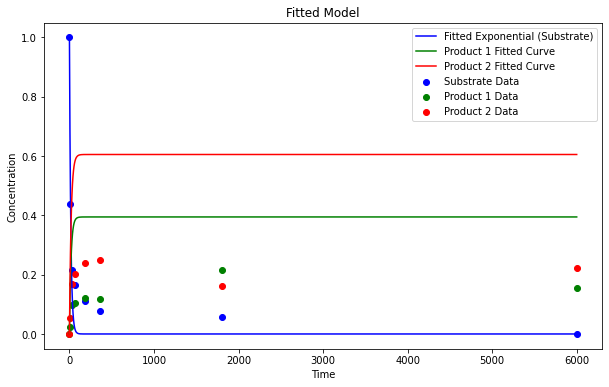

Optimal parameters:
k_depletion: 0.06277544404027086
k_formation1: 0.0535247662434827
k_formation2: 0.05024295432485864
fraction 1: 0.39467646875912005
fraction 2: 0.60532353124088


In [6]:
x_values = np.linspace(0, 6000, 1000)

# Generate points for the fitted curves for substrate and products
substrate_fit = initial_dna_depletion(x_values, k_depletion_opt)
product1_fit1, product2_fit1 = product_formation_system_1(x_values, k_formation1_opt1, k_formation2_opt1, fraction_opt)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot the original data
plt.scatter(time_data, substrate_data, label='Substrate Data', color='blue')
plt.scatter(time_data, product_data1, label='Product 1 Data', color='green')
plt.scatter(time_data, product_data2, label='Product 2 Data', color='red')

# Plot the fitted curves
plt.plot(x_values, substrate_fit, 'b-', label='Fitted Exponential (Substrate)')
plt.plot(x_values, product1_fit1, 'g-', label='Product 1 Fitted Curve')
plt.plot(x_values, product2_fit1, 'r-', label='Product 2 Fitted Curve')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fitted Model')
plt.legend()
plt.show()

# Print optimal parameters
print("Optimal parameters:")
print("k_depletion:", k_depletion_opt)
print("k_formation1:", k_formation1_opt1)
print("k_formation2:", k_formation2_opt1)
print("fraction 1:", fraction_opt)
print("fraction 2:", 1-fraction_opt)

## Determine the quality of the fit 

In [7]:
# Calculate R-squared for substrate and products
r_squared_substrate = r_squared(substrate_data, initial_dna_depletion(time_data, k_depletion_opt))
r_squared_product1 = r_squared(product_data1, product_formation_system_1(time_data, k_formation1_opt1, k_formation2_opt1, 
                                                                        fraction_opt))

# Calculate sum of squared residuals for substrate and products
ssr_substrate = sum_squared_residuals(substrate_data, initial_dna_depletion(time_data, k_depletion_opt))
ssr_product1 = sum_squared_residuals(product_data1, product_formation_system_1(time_data, k_formation1_opt1, k_formation2_opt1, 
                                                                        fraction_opt))

print("R-squared (Substrate):", r_squared_substrate)
print("R-squared (Product 1):", r_squared_product1)

print("Sum of Squared Residuals (Substrate):", ssr_substrate)
print("Sum of Squared Residuals (Product 1):", ssr_product1)


R-squared (Substrate): 0.9279503780942582
R-squared (Product 1): -48.01860618809384
Sum of Squared Residuals (Substrate): 0.054419475698327294
Sum of Squared Residuals (Product 1): 1.6132452209305828
